In [ ]:
!pip3 install --upgrade tensorflow==2.7.0 
!pip3 install --upgrade tensorflow-quantum 
!pip3 install matplotlib seaborn

  Obtaining dependency information for MarkupSafe>=2.1.1 from https://files.pythonhosted.org/packages/de/e2/32c14301bb023986dff527a49325b6259cab4ebb4633f69de54af312fc45/MarkupSafe-2.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached MarkupSafe-2.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
Using cached MarkupSafe-2.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Not uninstalling markupsafe at /shared-libs/python3.8/py-core/lib/python3.8/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.


In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/root/venv/lib/python3.8/site-packages/pkg_resources/__init__.py'>

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

2023-08-26 08:50:46.225425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-26 08:50:46.225470: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-26 08:50:50.047417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-26 08:50:50.047456: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-26 08:50:50.047478: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-4029068e-263e-4c12-9932-d3ac72036324): /proc/driver/nvidia/version does not exist
2023-08-26 08:50:50.047789: I tensorfl

In [ ]:
# load data mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

#cek length of data 
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
print(x_train.shape, x_test.shape)

Number of original training examples: 60000
Number of original test examples: 10000
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
#dunction for filter data number 3 dan number 6 
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


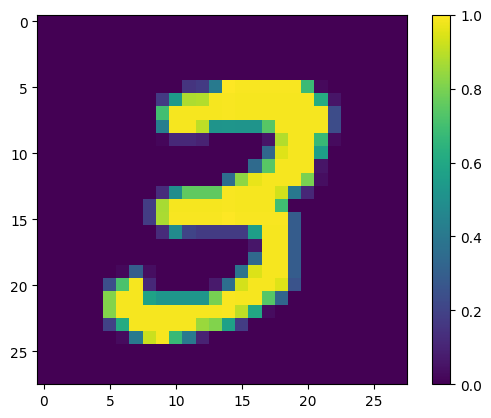

In [ ]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

True


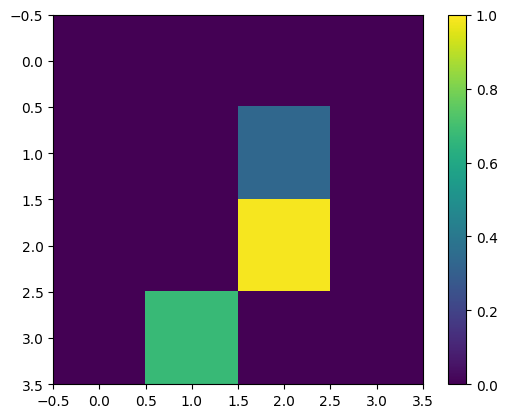

In [ ]:
# filter data to 4 x 4 size 
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

# data image after resize 
print(y_train[0])
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
        orig_x[tuple(x.flatten())] = x
        mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
        x = orig_x[flatten_x]
        labels = mapping[flatten_x]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(next(iter(labels)))
        else:
            # Throw out images that match more than one label.
            pass

    num_uniq_4 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_8 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_4)
    print("Number of unique 6s: ", num_uniq_8)
    print("Number of unique contradicting labels (both 4 and 8): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)


In [ ]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 4 and 8):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


In [ ]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [ ]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 4 and 8):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

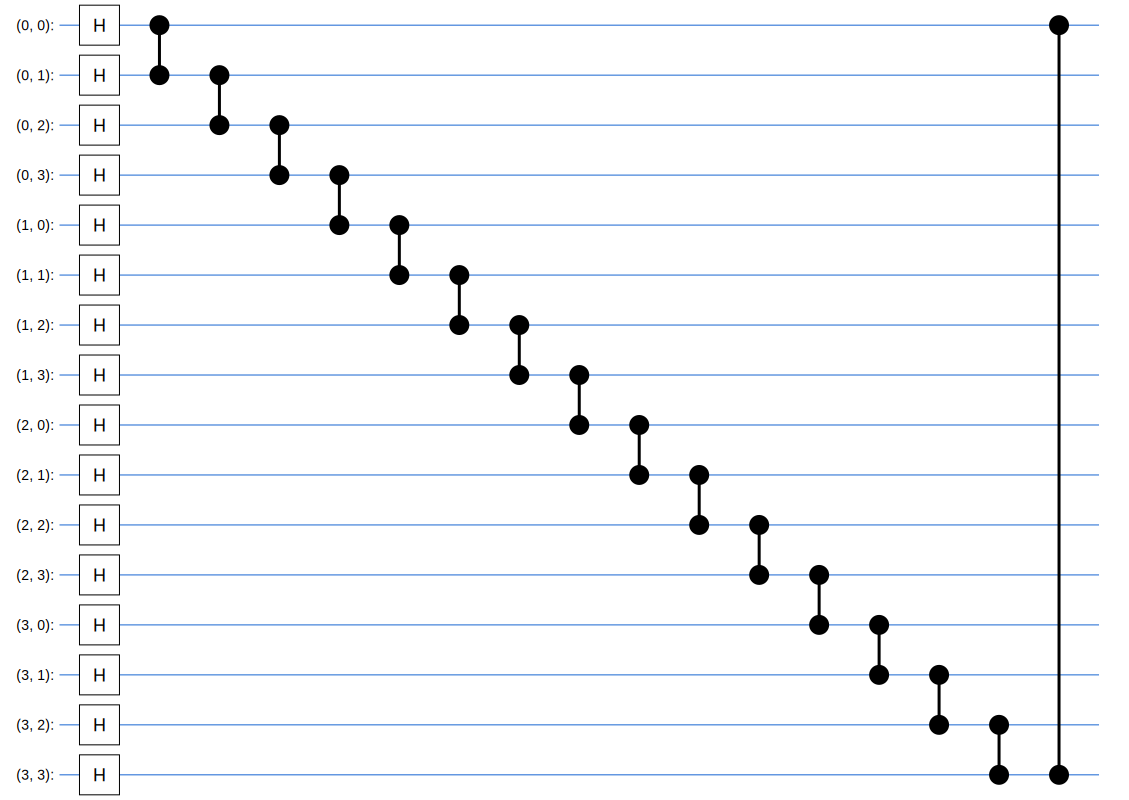

In [ ]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(4, 4)))

In [ ]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

# convert data to circuit 
x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# convert data to tensor format 
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

print(x_train_tfcirc.shape , x_test_tfcirc.shape)

(10338,) (1968,)


In [ ]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T

# change data target to 1 or -1 
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

print(y_train_hinge.shape, y_test_hinge.shape)

(10338,) (1968,)


In [ ]:
x_train_bin[0]

array([[[0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [1.],
        [0.]],

       [[0.],
        [1.],
        [0.],
        [0.]]], dtype=float32)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


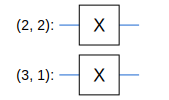

In [ ]:
SVGCircuit(x_train_circ[0])

In [ ]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])
    

    
def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


# def two_qubit_pool(source_qubit, sink_qubit, symbols):
#     """Make a Cirq circuit to do a parameterized 'pooling' operation, which
#     attempts to reduce entanglement down from two qubits to just one."""
#     pool_circuit = cirq.Circuit()
#     sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
#     source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
#     pool_circuit.append(sink_basis_selector)
#     pool_circuit.append(source_basis_selector)
#     pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
#     pool_circuit.append(sink_basis_selector**-1)
#     return pool_circuit

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


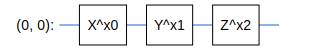

In [ ]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


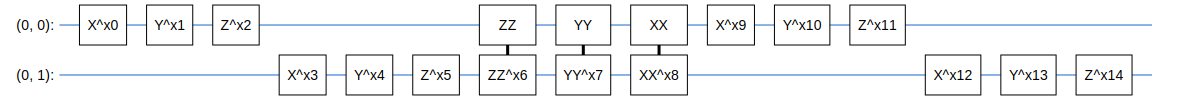

In [ ]:

SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

In [ ]:
qubits = cirq.GridQubit.rect(1, 2)
symbols = sympy.symbols('x0:6')

# Create the circuit
circuit = two_qubit_pool(qubits[0], qubits[1], symbols)

# Visualize the circuit
SVGCircuit(circuit)

#SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), *sympy.symbols('x0:6')))

NameError: name 'two_qubit_pool' is not defined

In [ ]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit



def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit
  
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)



findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

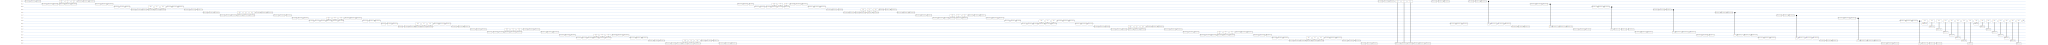

In [ ]:
qubits = cirq.GridQubit.rect(4, 4)
readout = cirq.GridQubit(1,2)
circuit = cirq.Circuit()


symbols = sympy.symbols('qconv0:84')
circuit += quantum_conv_circuit(qubits , symbols[0:15]) # range symbols always 16
circuit += quantum_pool_circuit(qubits[:8], qubits[8:], symbols[15:21])


readout_qnn = cirq.GridQubit(1, 3)
data_qubits_qnn = cirq.GridQubit.rect(4, 4)[8:]

builder = CircuitLayerBuilder( data_qubits = data_qubits_qnn, readout=readout_qnn)

# Then add layers (experiment by adding more).
builder.add_layer(circuit, cirq.XX, "xx1")
builder.add_layer(circuit, cirq.ZZ, "zz1")

model_readout = circuit.append(cirq.H(cirq.GridQubit(1, 3)))

SVGCircuit(circuit)


In [ ]:
readout_operators = cirq.Z(qubits[-1])

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(qubits))

quantum_model = tfq.layers.PQC(circuit,
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

In [ ]:
len(y_train_hinge), x_train_tfcirc.shape

(10338, TensorShape([10338]))

In [ ]:
len(y_test_hinge), x_test_tfcirc.shape

(1968, TensorShape([1968]))

In [ ]:
EPOCH = 3
BATCH_SIZE = 32



NUM_EXAMPLES = 500
#NUM_EXAMPLES = len(x_train_tfcirc)

NUM_EXAMPLES

500

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_train_tfcirc_sub.shape , y_train_hinge_sub.shape

(TensorShape([500]), (500,))

In [ ]:
import collections, numpy
collections.Counter(y_train_hinge_sub)

Counter({1.0: 230, -1.0: 270})

In [ ]:


# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    return tf.reduce_mean(result)


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[hinge_accuracy])

history = qcnn_model.fit(x=x_train_tfcirc_sub,
                         y=y_train_hinge_sub,
                         batch_size=16,
                         epochs=EPOCH,
                         verbose=1,
                         validation_data=(x_test_tfcirc , y_test_hinge))

Epoch 1/3
32/32 [==============================] - 155s 5s/step - loss: 0.9126 - hinge_accuracy: 0.6367 - val_loss: 0.6781 - val_hinge_accuracy: 0.7698
Epoch 2/3
32/32 [==============================] - 188s 6s/step - loss: 0.5142 - hinge_accuracy: 0.8027 - val_loss: 0.4489 - val_hinge_accuracy: 0.8333
Epoch 3/3
32/32 [==============================] - 189s 6s/step - loss: 0.4498 - hinge_accuracy: 0.8320 - val_loss: 0.4370 - val_hinge_accuracy: 0.8333


In [ ]:
history.history

{'loss': [0.912613570690155, 0.5141589641571045, 0.44983139634132385],
 'hinge_accuracy': [0.63671875, 0.802734375, 0.83203125],
 'val_loss': [0.6780843138694763, 0.4488929212093353, 0.43697038292884827],
 'val_hinge_accuracy': [0.769817054271698,
  0.8333333134651184,
  0.8333333134651184]}

In [ ]:
import pandas as pd
df_history = pd.DataFrame()
df_history['accuracy']  = history.history['hinge_accuracy']
df_history['loss']      = history.history['loss']
df_history['val_accuracy'] = history.history['val_hinge_accuracy']
df_history['val_loss']  = history.history['val_loss']

df_history.to_csv("history.csv", index = False)

print(df_history.shape)
df_history.head()

(3, 4)


,accuracy,loss,val_accuracy,val_loss
0,0.636719,0.912614,0.769817,0.678084
1,0.802734,0.514159,0.833333,0.448893
2,0.832031,0.449831,0.833333,0.436970


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4029068e-263e-4c12-9932-d3ac72036324' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>